# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-11-16
* 코드 작성 목적: NLP 및 LDA 토픽 모델링

## 참조 코드 - Topic Modeling using LDA

* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import *

In [3]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 처리

## A. 크롤링 데이터 불러오기

In [6]:
week_1st = pd.read_csv("../data/[속보]_['10']월_1기간_news_data.csv")
week_2nd = pd.read_csv("../data/[속보]_['10']월_2기간_news_data.csv")
week_3rd = pd.read_csv("../data/[속보]_['10']월_3기간_news_data.csv")
week_4th = pd.read_csv("../data/[속보]_['10']월_4기간_news_data.csv")

In [7]:
print(week_1st.shape)
print(week_2nd.shape)
print(week_3rd.shape)
print(week_4th.shape)

(793, 4)
(800, 4)
(643, 4)
(800, 4)


In [8]:
docs_1 = []
for idx in range(len(week_1st)):
    docs_1.append(week_1st['Title'][idx])

docs_2 = []
for idx in range(len(week_2nd)):
    docs_2.append(week_2nd['Title'][idx])

docs_3 = []
for idx in range(len(week_3rd)):
    docs_3.append(week_3rd['Title'][idx])

docs_4 = []
for idx in range(len(week_4th)):
    docs_4.append(week_4th['Title'][idx])

In [9]:
print(docs_1)
print(docs_2)
print(docs_3)
print(docs_4)

['[속보] 이스라엘군, 레바논 남부 접경 마을 20여곳 소개령', '[속보] 나토 “한국 등 인태 4개국, 나토 국방장관회의 첫 참석 예정”', '[속보] 이시바 시게루, 일본 총리 공식 선출…오늘 새 내각 출범', '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"', '[속보] 이스라엘 "레바논 수도 베이루트 정밀 폭격"', '[속보]9월 수출 7.5% 증가…반도체 136억달러 ‘역대 최대’', '[속보]광양 23층 아파트서 투신 19세女…극적 구조 성공', '[속보] 이스라엘군 "레바논 남부 \'지상 습격\' 시작…헤즈볼라 테러 목표...', '[속보]“北으로 돌아갈래”…마을버스 훔쳐 통일대교 건너려던 탈북민...', '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범', '[속보] 이스라엘, 레바논 접경지 봉쇄 거센 포격…지상전 조짐', '[속보] 北유엔대사 "합법적 자위권 놓고 과거로 돌아가지 않을 것"', '[속보] 윤대통령 "북, 핵무기 사용 기도하는 그날 정권 종말의 날"', '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범', '[속보] 이스라엘군, 레바논 향해 ‘국지적 침공’ 시작···지상전 초읽...', '[속보] 이스라엘 "방공망 완벽 준비…이란, 공격시 대가치러야"', '[속보]비트코인 3% 대 급락, 6만4000 달러선 깨져…‘이시바 쇼크’ 탓?', '[속보] 이스라엘 "레바논 지상작전 되도록 신속히 완료"', '[속보] 日이시바 총리 "납북 피해자 문제 해결에 강한 결의"', '[속보] "헤즈볼라, 이스라엘 지상군 레바논 진입 부인"<AFP>', '[속보] 美백악관 "이란, 이스라엘 직접 군사공격시 심각한 결과 있을것...', '[속보] 이스라엘 "지난 1년간 레바논서 수십회 소규모 지상작전"', '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"', '[속보] 롯데 레이예스, 시즌 최종전서 202안타…최다안타 신기록', '[속보] 미국 동남부 항만 폐쇄·파업 시작…노사협상 결렬'

## B. 구두점 처리

In [10]:
# 제거할 문자와 그 대체값을 딕셔너리로 정의
remove_dict = {
    '.': ' ',   # 마침표 제거
    ',': ' ',   # 쉼표 제거
    "'": ' ',   # 작은따옴표 제거
    '"': ' ',   # 큰따옴표 제거
    '·': ' ',  # 중간 점을 공백으로 대체
    '=': ' ',   # 등호 제거
    '\\n': ' ',  # 개행 문자 제거
    '[': ' ',
    ']': ' ',
    '…': ' ',
    '\\': ' '
}

In [11]:
# 여러 문자 제거를 위한 함수 생성
def CleanText(text, remove_dict):
    for key, value in remove_dict.items():
        text = text.replace(key, value)
    return text

In [12]:
doc_set_1 = []
for doc in docs_1:
    doc_set_1.append(CleanText(doc, remove_dict))

doc_set_2 = []
for doc in docs_2:
    doc_set_2.append(CleanText(doc, remove_dict))

doc_set_3 = []
for doc in docs_3:
    doc_set_3.append(CleanText(doc, remove_dict))

doc_set_4 = []
for doc in docs_4:
    doc_set_4.append(CleanText(doc, remove_dict))

In [13]:
print(doc_set_1)
print(doc_set_2)
print(doc_set_3)
print(doc_set_4)

[' 속보  이스라엘군  레바논 남부 접경 마을 20여곳 소개령', ' 속보  나토 “한국 등 인태 4개국  나토 국방장관회의 첫 참석 예정”', ' 속보  이시바 시게루  일본 총리 공식 선출 오늘 새 내각 출범', ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ', ' 속보  이스라엘  레바논 수도 베이루트 정밀 폭격 ', ' 속보 9월 수출 7 5% 증가 반도체 136억달러 ‘역대 최대’', ' 속보 광양 23층 아파트서 투신 19세女 극적 구조 성공', ' 속보  이스라엘군  레바논 남부  지상 습격  시작 헤즈볼라 테러 목표   ', ' 속보 “北으로 돌아갈래” 마을버스 훔쳐 통일대교 건너려던 탈북민   ', ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범', ' 속보  이스라엘  레바논 접경지 봉쇄 거센 포격 지상전 조짐', ' 속보  北유엔대사  합법적 자위권 놓고 과거로 돌아가지 않을 것 ', ' 속보  윤대통령  북  핵무기 사용 기도하는 그날 정권 종말의 날 ', ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범', ' 속보  이스라엘군  레바논 향해 ‘국지적 침공’ 시작   지상전 초읽   ', ' 속보  이스라엘  방공망 완벽 준비 이란  공격시 대가치러야 ', ' 속보 비트코인 3% 대 급락  6만4000 달러선 깨져 ‘이시바 쇼크’ 탓?', ' 속보  이스라엘  레바논 지상작전 되도록 신속히 완료 ', ' 속보  日이시바 총리  납북 피해자 문제 해결에 강한 결의 ', ' 속보   헤즈볼라  이스라엘 지상군 레바논 진입 부인 <AFP>', ' 속보  美백악관  이란  이스라엘 직접 군사공격시 심각한 결과 있을것   ', ' 속보  이스라엘  지난 1년간 레바논서 수십회 소규모 지상작전 ', ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ', ' 속보  롯데 레이예스  시즌 최종전서 202안타 최다안타 신기록', ' 속보  미국 동남부 항만 폐쇄 파업 시작 노사협상 결렬', 

## C. 불용어 및 자연어 처리

In [14]:
terms_1 = []
terms_2 = []
terms_3 = []
terms_4 = []

In [15]:
stop_word = '속보 그 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓'
stopword_list = stop_word.split(' ')
print(stopword_list)

['속보', '그', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [16]:
for w in doc_set_1:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_1.append(stop_tokens)

for w in doc_set_2:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_2.append(stop_tokens)

for w in doc_set_3:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_3.append(stop_tokens)

for w in doc_set_4:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_4.append(stop_tokens)

In [17]:
print(terms_1)
print(terms_2)
print(terms_3)
print(terms_4)

[['이스라엘군', '레바논', '남부', '접경', '마을', '곳', '소개', '령'], ['나토', '한국', '인태', '개국', '나토', '국방', '장관', '회의', '첫', '참석', '예정'], ['시바', '시게루', '일본', '총리', '공식', '선출', '오늘', '새', '내각', '출범'], ['헤즈볼라', '텔아비브', '인근', '모사드', '본부', '미사일', '공격'], ['이스라엘', '레바논', '수도', '베이루트', '정밀', '폭격'], ['수출', '증가', '반도체', '역대', '최대'], ['광양', '층', '아파트', '투신', '세', '극적', '구조', '성공'], ['이스라엘군', '레바논', '남부', '지상', '습격', '시작', '헤즈볼라', '테러', '목표'], ['마을', '버스', '통일대교', '탈북민'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘', '레바논', '접경', '봉쇄', '거', '포격', '지상전', '조짐'], ['유엔', '대사', '합법', '자위권', '과거'], ['윤', '대통령', '북', '핵무기', '사용', '기도', '그날', '정권', '종말', '날'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘군', '레바논', '향', '국', '지적', '침공', '시작', '지상전', '초'], ['이스라엘', '방공', '망', '완벽', '준비', '이란', '공격', '시', '대가'], ['비트코인', '급락', '달러', '선', '시바', '쇼크', '탓'], ['이스라엘', '레바논', '지상', '작전', '완료'], ['시바', '총리', '납북', '피해자', '해결', '결의'], ['헤즈볼라', '이스라엘', '지상군', '레바논', '진입', '부인'], ['백악관', '이란', '이스라엘', '직접', '군사

## D. 사전과 문서-단어행렬 생성

In [18]:
#training vocabulary
dictionary_1 = corpora.Dictionary(terms_1)
dictionary_2 = corpora.Dictionary(terms_2)
dictionary_3 = corpora.Dictionary(terms_3)
dictionary_4 = corpora.Dictionary(terms_4)

In [19]:
## 문서-단어 행렬(document-term matrix) 생성
corpus_1 = [dictionary_1.doc2bow(term) for term in terms_1]
corpus_2 = [dictionary_2.doc2bow(term) for term in terms_2]
corpus_3 = [dictionary_3.doc2bow(term) for term in terms_3]
corpus_4 = [dictionary_4.doc2bow(term) for term in terms_4]

In [20]:
print(dictionary_1, '\n')
print(dictionary_2, '\n')
print(dictionary_3, '\n')
print(dictionary_4)

Dictionary<1836 unique tokens: ['곳', '남부', '레바논', '령', '마을']...> 

Dictionary<1885 unique tokens: ['대통령', '라오스', '시바', '정상회담', '첫']...> 

Dictionary<1521 unique tokens: ['가능성', '사망', '신와르', '이스라엘군', '지도자']...> 

Dictionary<1866 unique tokens: ['단계', '대응', '미군기지', '발령', '부산']...>


In [21]:
print(corpus_1, '\n')
print(corpus_2, '\n')
print(corpus_3, '\n')
print(corpus_4)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(2, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(1, 1), (2, 1), (6, 1), (34, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (58, 1), (59, 1), (60, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (7, 1), (37, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)], [(66, 1), (67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (6, 1), (55, 1), (64, 1),

## E. TF-IDF 계산

In [22]:
#tfidf document-term matrix
tfidf_1 = models.TfidfModel(corpus_1)
corpus_tfidf_1 = tfidf_1[corpus_1]
corpus_tfidf_1[0][:5]

[(0, 0.4497113250517876),
 (1, 0.3096314607369322),
 (2, 0.18754206067480705),
 (3, 0.4030180369468358),
 (4, 0.3096314607369322)]

In [23]:
#tfidf document-term matrix
tfidf_2 = models.TfidfModel(corpus_2)
corpus_tfidf_2 = tfidf_2[corpus_2]
corpus_tfidf_2[0][:5]

[(0, 0.2719291481728554),
 (1, 0.4337267068907654),
 (2, 0.378115103195373),
 (3, 0.4729167834781762),
 (4, 0.36150498164398825)]

In [24]:
#tfidf document-term matrix
tfidf_3 = models.TfidfModel(corpus_3)
corpus_tfidf_3 = tfidf_3[corpus_3]
corpus_tfidf_3[0][:5]

[(0, 0.4452084779747268),
 (1, 0.2921068989258251),
 (2, 0.3117141000663088),
 (3, 0.4028381893556479),
 (4, 0.47883966806431966)]

In [25]:
#tfidf document-term matrix
tfidf_4 = models.TfidfModel(corpus_4)
corpus_tfidf_4 = tfidf_4[corpus_4]
corpus_tfidf_4[0][:5]

[(0, 0.3508376666903285),
 (1, 0.2841525646547981),
 (2, 0.47969389896728176),
 (3, 0.4472311952202524),
 (4, 0.3687031817605941)]

## F. LDA 분석

In [26]:
model_1 = gensim.models.LdaModel(
    corpus_1,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_1,
    random_state=42
)

In [27]:
model_2 = gensim.models.LdaModel(
    corpus_2,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_2,
    random_state=42
)

In [28]:
model_3 = gensim.models.LdaModel(
    corpus_3,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_3,
    random_state=42
)

In [29]:
model_4 = gensim.models.LdaModel(
    corpus_4,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_4,
    random_state=42
)

In [30]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
print(model_1.show_topics(4, 10), '\n')
print(model_2.show_topics(4, 10), '\n')
print(model_3.show_topics(4, 10), '\n')
print(model_4.show_topics(4, 10))

[(2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바" + 0.007*"이스라엘" + 0.006*"일화" + 0.006*"음주운전" + 0.006*"협력" + 0.006*"입건"'), (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤" + 0.007*"한일" + 0.007*"과" + 0.007*"자" + 0.006*"뉴욕증시" + 0.006*"거짓말"'), (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국" + 0.007*"판매" + 0.007*"사태" + 0.007*"감소" + 0.006*"검찰" + 0.006*"원주"'), (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기" + 0.013*"군" + 0.010*"서울" + 0.009*"휴학" + 0.009*"공항" + 0.009*"이스라엘"')] 

[(2, '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스" + 0.007*"마감" + 0.007*"검찰" + 0.007*"호" + 0.006*"홍명보" + 0.006*"한국"'), (6, '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율" + 0.008*"영풍" + 0.008*"금정" + 0.008*"유력" + 0.007*"주장" + 0.007*"확보"'), (3, '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당" + 0.006*"중단" + 0.006*"행위" + 0.006*"즉각" + 0.006*"긴장" + 0.006*"한반도"'), (4, '0.014*"노벨" + 0.013

In [31]:
NUM_TOPICS = 9
TOP_N = 20

In [32]:
word_dict_1 = {}
word_dict_2 = {}
word_dict_3 = {}
word_dict_4 = {}

In [33]:
for i in range(NUM_TOPICS):
  words = model_1.show_topic(i, topn=TOP_N)
  word_dict_1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_1 = pd.DataFrame(word_dict_1)

In [34]:
for i in range(NUM_TOPICS):
  words = model_2.show_topic(i, topn=TOP_N)
  word_dict_2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_2 = pd.DataFrame(word_dict_2)

In [35]:
for i in range(NUM_TOPICS):
  words = model_3.show_topic(i, topn=TOP_N)
  word_dict_3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_3 = pd.DataFrame(word_dict_3)

In [36]:
for i in range(NUM_TOPICS):
  words = model_4.show_topic(i, topn=TOP_N)
  word_dict_4['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_4 = pd.DataFrame(word_dict_4)

In [37]:
word_df_1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,대통령,윤,윤,대통령,레바논,전자,레바논,이스라엘,필리핀
1,윤,대통령,민주,윤,도착,영업,이스라엘,고려아연,대통령
2,이스라엘,특검법,대통령,대통령실,국민,삼성,의회,사주,뉴욕증시
3,싱가포르,부결,대응,김건희,체류,익,헤즈볼라,헤즈볼라,쓰레기
4,필리핀,이란,시바,위,수송기,예고,미국,윤,부양
5,이란,전자,이스라엘,북한,군,활,판매,한일,일제
6,순방,레바논,일화,여사,서울,소비,사태,과,새
7,내일,이스라엘,음주운전,국회,휴학,성장,감소,자,총리
8,사업,공격,협력,국악,공항,부진,검찰,뉴욕증시,나스닥
9,보복,김건희,입건,풍선,이스라엘,투자,원주,거짓말,전략


In [38]:
word_df_2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한강,한강,한강,한강,노벨,대통령,당선,무인기,한국
1,명태,노벨문학상,북한,대통령,한국,은,교육감,한국,무인기
2,균,수상,합참,최고,한강,대통령실,정근,군수,평양
3,노벨문학상,무인기,선,국민,윤,개월,서울시,곡성,침투
4,수상,평양,뉴스,진보당,정부,기준금리,율,평양,북
5,국감,합참,마감,중단,율,택시,영풍,대통령,확인
6,노벨상,작가,검찰,행위,수상,종말,금정,윤,한강
7,추가,한국,호,즉각,투표,최근,유력,조상래,합참
8,첫,정부,홍명보,긴장,무인기,한국,주장,민주당,쾌거
9,운영,대통령,한국,한반도,국민,인하,확보,아세안,줄


In [39]:
word_df_3

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한국,한동훈,러북,김건희,러시아,파병,경제,윤,경제
1,시리즈,면담,북한,대통령실,경찰,국정원,대통령,대통령,성장
2,위해,대통령,이번,여사,대통령,러시아,한동훈,대통령실,대통령
3,대통령,윤,정부,한국,파병,김,대통령실,파병,북한
4,감찰관,신와르,일정,검찰,북한,오자,발표,러시아,한동훈
5,유럽,사망,당선,의혹,한동훈,여사,대표,한동훈,인하
6,발,인천,안보,북한,대표,북한,회의,도박,치
7,지난해,김여사,파병,협력,동행,북,국정감사,상치,발표
8,진출,일정,합의,오자,명령,이동,윤,판매,윤
9,윤,활동,국민,글,출석,뜻,여사,전월,조치


In [40]:
word_df_4

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한국,북한,대통령실,경제,위,이란,이란,영업,북한
1,북한,대통령실,파병,대통령,대통령실,북한,국정원,북한,이란
2,파병,영업,대통령,성장,북한,이스라엘,이스라엘,파병,삼성
3,세,주간,윤,률,장관,차,북,익,주간
4,우승,파병,지원,한동훈,윤,비트코인,대북,개혁,고려아연
5,김수미,이스라엘,북한,위해,률,대통령실,코스피,투입,이스라엘
6,영업,이란,법,세,내년,대응,러시아,전자,백악관
7,계약,검토,러시아,향년,가능성,국정원,성장,실적,발사
8,별세,키,뉴욕증시,올해,성장,휴학,범,북,이동
9,신세계,실적,검토,김수미,수출,의대,취소,전선,파병


In [41]:
model_1.print_topics(num_words=5)

[(0, '0.021*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"싱가포르" + 0.008*"필리핀"'),
 (1, '0.014*"윤" + 0.014*"대통령" + 0.009*"특검법" + 0.008*"부결" + 0.008*"이란"'),
 (2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바"'),
 (3, '0.016*"대통령" + 0.016*"윤" + 0.009*"대통령실" + 0.009*"김건희" + 0.009*"위"'),
 (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기"'),
 (5, '0.016*"전자" + 0.013*"영업" + 0.013*"삼성" + 0.012*"익" + 0.007*"예고"'),
 (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국"'),
 (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤"'),
 (8, '0.014*"필리핀" + 0.010*"대통령" + 0.008*"뉴욕증시" + 0.008*"쓰레기" + 0.008*"부양"')]

In [42]:
model_2.print_topics(num_words=5)

[(0, '0.016*"한강" + 0.013*"명태" + 0.013*"균" + 0.010*"노벨문학상" + 0.008*"수상"'),
 (1, '0.028*"한강" + 0.021*"노벨문학상" + 0.019*"수상" + 0.012*"무인기" + 0.010*"평양"'),
 (2, '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스"'),
 (3, '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당"'),
 (4, '0.014*"노벨" + 0.013*"한국" + 0.010*"한강" + 0.008*"윤" + 0.007*"정부"'),
 (5, '0.015*"대통령" + 0.012*"은" + 0.007*"대통령실" + 0.007*"개월" + 0.007*"기준금리"'),
 (6, '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율"'),
 (7, '0.015*"무인기" + 0.015*"한국" + 0.011*"군수" + 0.009*"곡성" + 0.009*"평양"'),
 (8, '0.015*"한국" + 0.014*"무인기" + 0.014*"평양" + 0.012*"침투" + 0.012*"북"')]

In [43]:
model_3.print_topics(num_words=5)

[(0, '0.012*"한국" + 0.012*"시리즈" + 0.009*"위해" + 0.009*"대통령" + 0.007*"감찰관"'),
 (1, '0.024*"한동훈" + 0.019*"면담" + 0.018*"대통령" + 0.018*"윤" + 0.012*"신와르"'),
 (2, '0.010*"러북" + 0.010*"북한" + 0.008*"이번" + 0.008*"정부" + 0.008*"일정"'),
 (3, '0.014*"김건희" + 0.014*"대통령실" + 0.011*"여사" + 0.010*"한국" + 0.009*"검찰"'),
 (4, '0.017*"러시아" + 0.017*"경찰" + 0.015*"대통령" + 0.015*"파병" + 0.012*"북한"'),
 (5, '0.017*"파병" + 0.015*"국정원" + 0.012*"러시아" + 0.012*"김" + 0.012*"오자"'),
 (6, '0.023*"경제" + 0.018*"대통령" + 0.017*"한동훈" + 0.013*"대통령실" + 0.013*"발표"'),
 (7, '0.016*"윤" + 0.015*"대통령" + 0.015*"대통령실" + 0.011*"파병" + 0.010*"러시아"'),
 (8, '0.019*"경제" + 0.012*"성장" + 0.010*"대통령" + 0.009*"북한" + 0.009*"한동훈"')]

In [44]:
model_4.print_topics(num_words=5)

[(0, '0.014*"한국" + 0.012*"북한" + 0.008*"파병" + 0.007*"세" + 0.007*"우승"'),
 (1, '0.018*"북한" + 0.012*"대통령실" + 0.009*"영업" + 0.008*"주간" + 0.008*"파병"'),
 (2, '0.019*"대통령실" + 0.018*"파병" + 0.014*"대통령" + 0.013*"윤" + 0.010*"지원"'),
 (3, '0.011*"경제" + 0.011*"대통령" + 0.009*"성장" + 0.008*"률" + 0.008*"한동훈"'),
 (4, '0.010*"위" + 0.007*"대통령실" + 0.007*"북한" + 0.007*"장관" + 0.006*"윤"'),
 (5, '0.012*"이란" + 0.010*"북한" + 0.010*"이스라엘" + 0.007*"차" + 0.007*"비트코인"'),
 (6, '0.011*"이란" + 0.010*"국정원" + 0.009*"이스라엘" + 0.008*"북" + 0.007*"대북"'),
 (7, '0.017*"영업" + 0.014*"북한" + 0.013*"파병" + 0.013*"익" + 0.011*"개혁"'),
 (8, '0.010*"북한" + 0.009*"이란" + 0.008*"삼성" + 0.008*"주간" + 0.007*"고려아연"')]

In [45]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)

for i in range(9):
    print(model_1.get_document_topics(corpus_1)[i], '\n')
    print(model_2.get_document_topics(corpus_2)[i], '\n')
    print(model_3.get_document_topics(corpus_3)[i], '\n')
    print(model_4.get_document_topics(corpus_4)[i])

[(0, 0.012348949), (1, 0.9011847), (2, 0.012352445), (3, 0.012350174), (4, 0.012357521), (5, 0.012349221), (6, 0.012357313), (7, 0.012352022), (8, 0.012347707)] 

[(0, 0.01587948), (1, 0.015877282), (2, 0.015877036), (3, 0.015879232), (4, 0.01587647), (5, 0.87297964), (6, 0.015873736), (7, 0.015882337), (8, 0.01587484)] 

[(0, 0.013889769), (1, 0.88887393), (2, 0.013889478), (3, 0.013890939), (4, 0.013890996), (5, 0.013889378), (6, 0.0138932355), (7, 0.013891137), (8, 0.013891144)] 

[(0, 0.015878286), (1, 0.01587561), (2, 0.015876135), (3, 0.015877528), (4, 0.8729801), (5, 0.015878063), (6, 0.01587816), (7, 0.01587882), (8, 0.015877297)]
[(8, 0.92589915)] 

[(0, 0.010102084), (1, 0.010104312), (2, 0.010107379), (3, 0.010105059), (4, 0.010107224), (5, 0.9191643), (6, 0.01010406), (7, 0.010103556), (8, 0.010102054)] 

[(0, 0.011112209), (1, 0.01112883), (2, 0.01111221), (3, 0.9110666), (4, 0.011117257), (5, 0.011116365), (6, 0.011117835), (7, 0.011115492), (8, 0.0111131715)] 

[(0, 0.01

## G. pyLDAvis를 이용한 시각화

In [46]:
pyLDAvis.enable_notebook()

In [47]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_1 = pyLDAvis.gensim_models.prepare(model_1, corpus_1, dictionary_1)

data_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.138651  0.140770       1        1  14.727157
1     -0.020589 -0.108162       2        1  14.236448
0      0.095489 -0.028589       3        1  13.787929
8      0.096978  0.067193       4        1  10.193169
5     -0.004197  0.000642       5        1   9.991826
3      0.081688  0.094158       6        1   9.915386
6     -0.109336 -0.049760       7        1   9.234851
7      0.012569 -0.047008       8        1   9.221345
2     -0.013952 -0.069244       9        1   8.691888, topic_info=      Term       Freq      Total Category  logprob  loglift
478     전자  20.000000  20.000000  Default  30.0000  30.0000
1713    영업  13.000000  13.000000  Default  29.0000  29.0000
1163    체류  13.000000  13.000000  Default  28.0000  28.0000
2      레바논  39.000000  39.000000  Default  27.0000  27.0000
1715     익  12.000000  12.000000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
693     부산   2.429167   9.423658   Topic9  -5.3337   1.0871
647    필리핀   3.093766  30.848268   Topic9  -5.0919   0.1431
642   싱가포르   2.540182  18.843814   Topic9  -5.2890   0.4388
136     개월   2.428568  16.897965   Topic9  -5.3340   0.5029
26      총리   2.428970  17.207897   Topic9  -5.3338   0.4849

[569 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1069      6  0.909976   가장
387       5  0.701455  가처분
1319      4  0.664090   가치
1674      9  0.650471    간
1627      7  0.671258   간격
...     ...       ...  ...
669       5  0.346282   흉기
669       8  0.692563   흉기
220       2  0.513706   흑자
220       3  0.256853   흑자
1687      5  0.687393   힌튼

[1122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 9, 6, 4, 7, 8, 3])

In [48]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_2 = pyLDAvis.gensim_models.prepare(model_2, corpus_2, dictionary_2)

data_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037908  0.131701       1        1  15.608354
4      0.040149  0.008517       2        1  13.683675
5     -0.144792 -0.139935       3        1  12.864848
7      0.047175 -0.044898       4        1  10.629746
6      0.163773 -0.044220       5        1  10.555122
0     -0.069619  0.102637       6        1  10.385832
8     -0.011278  0.037110       7        1  10.103557
2     -0.020355 -0.056118       8        1   8.659889
3      0.032855  0.005206       9        1   7.508977, topic_info=       Term       Freq      Total Category  logprob  loglift
48       수상  31.000000  31.000000  Default  30.0000  30.0000
440   노벨문학상  35.000000  35.000000  Default  29.0000  29.0000
442      한강  61.000000  61.000000  Default  28.0000  28.0000
966     교육감  13.000000  13.000000  Default  27.0000  27.0000
1754     당선  18.000000  18.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
94        윤   2.119621  27.468332   Topic9  -5.3417   0.0273
48       수상   2.120005  31.371449   Topic9  -5.3415  -0.1054
440   노벨문학상   2.119916  35.467358   Topic9  -5.3416  -0.2282
1771     개표   1.438551   8.231013   Topic9  -5.7293   0.8448
1247    목소리   1.438507   5.512613   Topic9  -5.7294   1.2456

[584 rows x 6 columns], token_table=      Topic      Freq Term
term                      
58        4  0.352214   가격
58        9  0.352214   가격
1039      7  0.843416   가장
1250      3  0.648182    간
1250      7  0.162046    간
...     ...       ...  ...
179       1  0.428422    힘
179       2  0.214211    힘
179       5  0.107106    힘
179       8  0.107106    힘
179       9  0.107106    힘

[1181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 8, 7, 1, 9, 3, 4])

In [49]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_3 = pyLDAvis.gensim_models.prepare(model_3, corpus_3, dictionary_3)

data_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.047596  0.156761       1        1  14.718256
1      0.110608 -0.004363       2        1  13.455291
6      0.091360 -0.079405       3        1  12.448978
4      0.028968  0.006723       4        1  11.389740
7      0.031512  0.019772       5        1  10.900545
0     -0.109219 -0.038959       6        1   9.361913
3     -0.125896  0.072723       7        1   9.327403
8     -0.027044 -0.097030       8        1   9.275740
2     -0.047885 -0.036221       9        1   9.122135, topic_info=    Term       Freq      Total Category  logprob  loglift
565   경제  22.000000  22.000000  Default  30.0000  30.0000
419  러시아  25.000000  25.000000  Default  29.0000  29.0000
538   한국  16.000000  16.000000  Default  28.0000  28.0000
113   경찰  14.000000  14.000000  Default  27.0000  27.0000
10    면담  22.000000  22.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
363  문다혜   1.657919   8.339734   Topic9  -5.4898   0.7790
85    개혁   1.657904   4.663581   Topic9  -5.4898   1.3602
391  국정원   1.657839  20.197061   Topic9  -5.4898  -0.1056
111   피해   1.657821   5.176664   Topic9  -5.4898   1.2558
812   위해   1.657801   8.086678   Topic9  -5.4899   0.8097

[597 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.633657  가능성
0         7  0.316828  가능성
329       7  0.697485   가담
1461      2  0.623318   가정
7         1  0.456521   가족
...     ...       ...  ...
159       2  0.110142    힘
159       3  0.220283    힘
159       4  0.330425    힘
159       5  0.110142    힘
159       9  0.220283    힘

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 5, 8, 1, 4, 9, 3])

In [50]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_4 = pyLDAvis.gensim_models.prepare(model_4, corpus_4, dictionary_4)

data_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.129762  0.025638       1        1  13.807245
7     -0.050862 -0.077139       2        1  12.355019
0      0.097899  0.003657       3        1  12.009848
2     -0.074203 -0.033998       4        1  11.511121
8      0.046698 -0.037053       5        1  10.671013
4     -0.011280  0.144540       6        1  10.438472
3      0.062228  0.089213       7        1  10.341022
5      0.088904 -0.076526       8        1  10.206403
6     -0.029621 -0.038332       9        1   8.659856, topic_info=     Term       Freq      Total Category  logprob  loglift
44      익  21.000000  21.000000  Default  30.0000  30.0000
82   대통령실  39.000000  39.000000  Default  29.0000  29.0000
222    한국  22.000000  22.000000  Default  28.0000  28.0000
171     세  15.000000  15.000000  Default  27.0000  27.0000
42     영업  30.000000  30.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
64     파병   2.420216  42.924584   Topic9  -5.3153  -0.4291
566    공격   2.126950  17.266819   Topic9  -5.4444   0.3524
60    대통령   2.105627  28.681641   Topic9  -5.4545  -0.1652
41     삼성   2.105382  19.205944   Topic9  -5.4546   0.2357
82   대통령실   2.105355  39.482202   Topic9  -5.4546  -0.4849

[634 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
839       7  0.657558  가까스로
209       1  0.331387   가능성
209       2  0.055231   가능성
209       3  0.055231   가능성
209       4  0.110462   가능성
...     ...       ...   ...
1326      3  0.120866    휴학
1326      4  0.241732    휴학
1326      8  0.362598    휴학
1326      9  0.120866    휴학
194       1  0.648354    흑자

[1286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 3, 9, 5, 4, 6, 7])

## H. LDA 토픽개수 지정

In [51]:
print('1st Week')
print('\nPerplexity: ', model_1.log_perplexity(corpus_1))
coherence_model_lda_1 = CoherenceModel(model=model_1, texts=terms_1, dictionary=dictionary_1, topn=10)
coherence_lda_1 = coherence_model_lda_1.get_coherence()
print('\nCoherence Score: ', coherence_lda_1)

1st Week

Perplexity:  -7.774768092351955

Coherence Score:  0.4280854063612424


In [52]:
print('2nd Week')
print('\nPerplexity: ', model_2.log_perplexity(corpus_2))
coherence_model_lda_2 = CoherenceModel(model=model_2, texts=terms_2, dictionary=dictionary_2, topn=10)
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)

2nd Week

Perplexity:  -7.780034901935663

Coherence Score:  0.39001315266563563


In [53]:
print('3rd Week')
print('\nPerplexity: ', model_3.log_perplexity(corpus_3))
coherence_model_lda_3 = CoherenceModel(model=model_3, texts=terms_3, dictionary=dictionary_3, topn=10)
coherence_lda_3 = coherence_model_lda_3.get_coherence()
print('\nCoherence Score: ', coherence_lda_3)

3rd Week

Perplexity:  -7.625432045610798

Coherence Score:  0.3611815157371397


In [54]:
print('4th Week')
print('\nPerplexity: ', model_4.log_perplexity(corpus_4))
coherence_model_lda_4 = CoherenceModel(model=model_4, texts=terms_4, dictionary=dictionary_4, topn=10)
coherence_lda_4 = coherence_model_lda_4.get_coherence()
print('\nCoherence Score: ', coherence_lda_4)

4th Week

Perplexity:  -7.9108841284388705

Coherence Score:  0.4563684003496933


## A. Perplexity - 낮을수록 좋음

In [55]:
perplexity_values_1 = []
perplexity_values_2 = []
perplexity_values_3 = []
perplexity_values_4 = []

In [56]:
for i in range(2, 6):
    ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus_1, num_topics=i, id2word = dictionary_1, random_state=42)
    perplexity_values_1.append(ldamodel_1.log_perplexity(corpus_1))

    ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus_2, num_topics=i, id2word = dictionary_2, random_state=42)
    perplexity_values_2.append(ldamodel_2.log_perplexity(corpus_2))

    ldamodel_3 = gensim.models.ldamodel.LdaModel(corpus_3, num_topics=i, id2word = dictionary_3, random_state=42)
    perplexity_values_3.append(ldamodel_3.log_perplexity(corpus_3))

    ldamodel_4 = gensim.models.ldamodel.LdaModel(corpus_4, num_topics=i, id2word = dictionary_4, random_state=42)
    perplexity_values_4.append(ldamodel_4.log_perplexity(corpus_4))

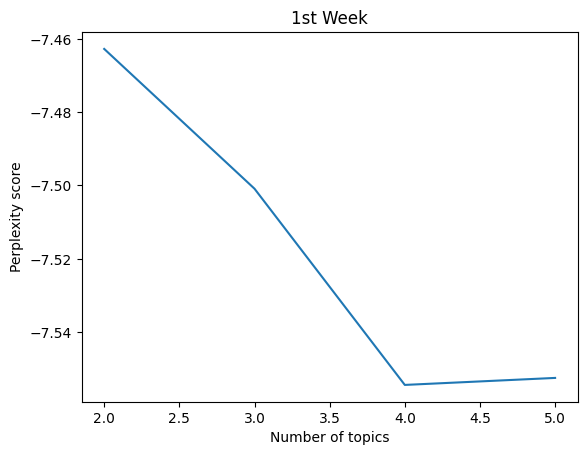

In [57]:
x = range(2, 6)
plt.plot(x, perplexity_values_1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

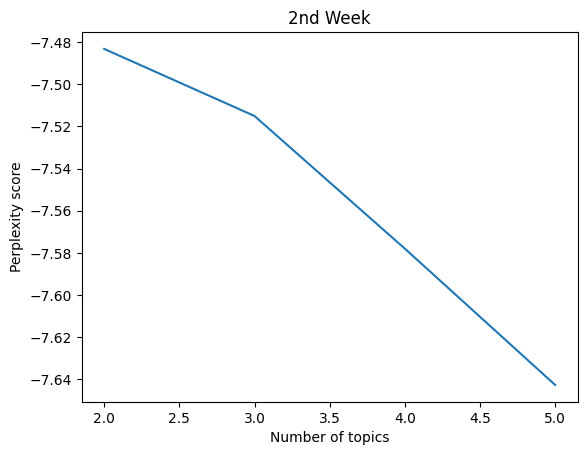

In [58]:
x = range(2, 6)
plt.plot(x, perplexity_values_2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

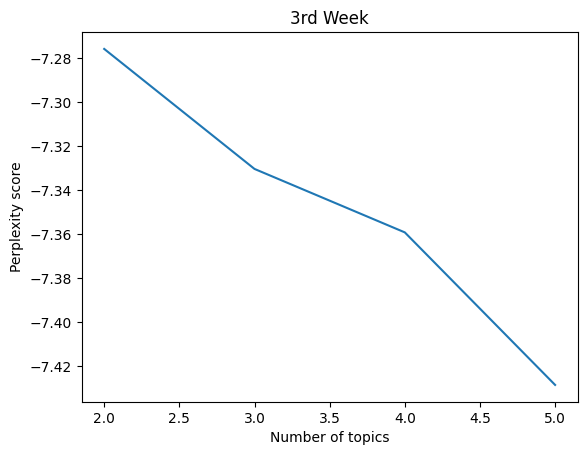

In [59]:
x = range(2, 6)
plt.plot(x, perplexity_values_3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

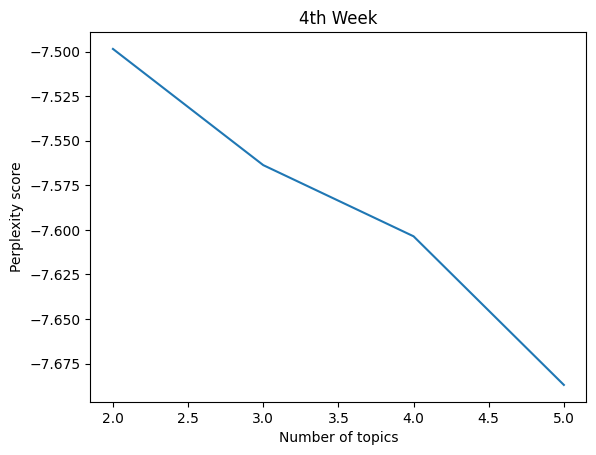

In [60]:
x = range(2, 6)
plt.plot(x, perplexity_values_4)
plt.title('4th Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

## B. Coherence - 높을수록 좋음

In [61]:
coherence_values_1 = []
coherence_values_2 = []
coherence_values_3 = []
coherence_values_4 = []

In [62]:
for i in range(2, 6):
    ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus_1, num_topics=i, id2word=dictionary_1, random_state=42)
    coherence_model_lda_1 = CoherenceModel(model=ldamodel_1, texts=terms_1, dictionary=dictionary_1, topn=10)
    coherence_lda_1 = coherence_model_lda_1.get_coherence()
    coherence_values_1.append(coherence_lda_1)

In [63]:
for i in range(2, 6):
    ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus_2, num_topics=i, id2word=dictionary_2, random_state=42)
    coherence_model_lda_2 = CoherenceModel(model=ldamodel_2, texts=terms_2, dictionary=dictionary_2, topn=10)
    coherence_lda_2 = coherence_model_lda_2.get_coherence()
    coherence_values_2.append(coherence_lda_2)

In [64]:
for i in range(2, 6):
    ldamodel_3 = gensim.models.ldamodel.LdaModel(corpus_3, num_topics=i, id2word=dictionary_3, random_state=42)
    coherence_model_lda_3 = CoherenceModel(model=ldamodel_3, texts=terms_3, dictionary=dictionary_3, topn=10)
    coherence_lda_3 = coherence_model_lda_3.get_coherence()
    coherence_values_3.append(coherence_lda_3)

In [65]:
for i in range(2, 6):
    ldamodel_4 = gensim.models.ldamodel.LdaModel(corpus_4, num_topics=i, id2word=dictionary_4, random_state=42)
    coherence_model_lda_4 = CoherenceModel(model=ldamodel_4, texts=terms_4, dictionary=dictionary_4, topn=10)
    coherence_lda_4 = coherence_model_lda_4.get_coherence()
    coherence_values_4.append(coherence_lda_4)

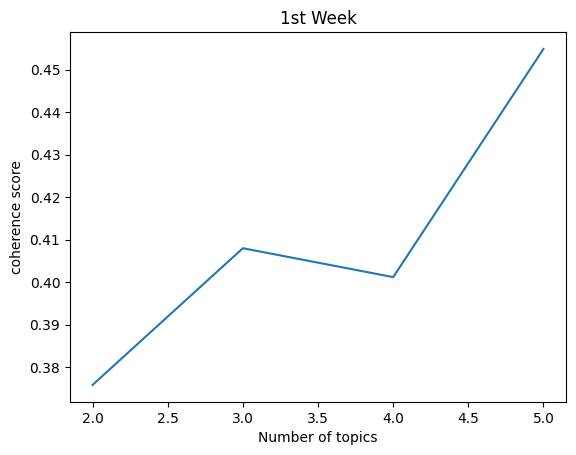

In [66]:
x = range(2, 6)
plt.plot(x, coherence_values_1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

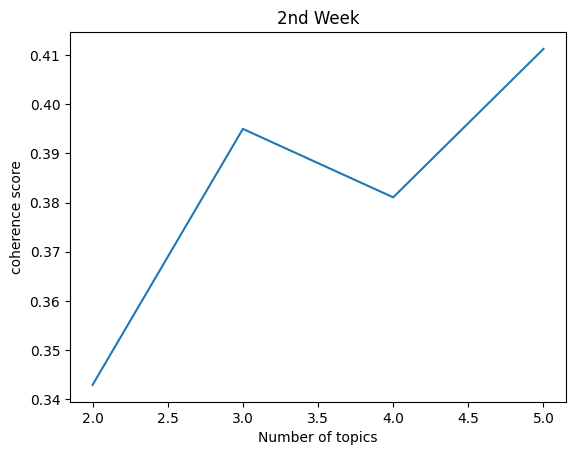

In [67]:
x = range(2, 6)
plt.plot(x, coherence_values_2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

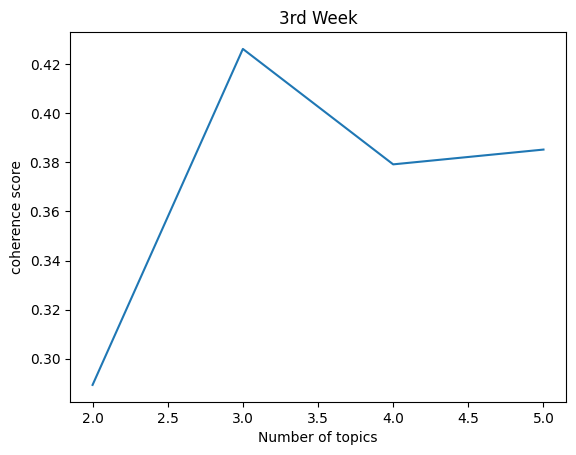

In [68]:
x = range(2, 6)
plt.plot(x, coherence_values_3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

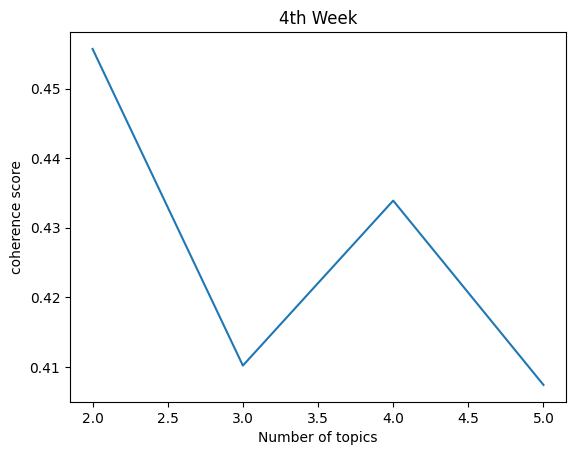

In [69]:
x = range(2, 6)
plt.plot(x, coherence_values_4)
plt.title('4th Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택

## I. 최종 LDA 분석

In [70]:
# range(2, 6) -> 2부터 5까지이므로 index에 2를 더함
print(
    coherence_values_1.index(max(coherence_values_1)) + 2,
    coherence_values_2.index(max(coherence_values_2)) + 2,
    coherence_values_3.index(max(coherence_values_3)) + 2,
    coherence_values_4.index(max(coherence_values_4)) + 2
)

5 5 3 2


In [71]:
NUM_TOPICS_1 = coherence_values_1.index(max(coherence_values_1)) + 2
NUM_TOPICS_2 = coherence_values_2.index(max(coherence_values_2)) + 2
NUM_TOPICS_3 = coherence_values_3.index(max(coherence_values_3)) + 2
NUM_TOPICS_4 = coherence_values_4.index(max(coherence_values_4)) + 2

In [72]:
final_model_1 = gensim.models.LdaModel(
    corpus_1,
    num_topics=NUM_TOPICS_1, # 출력 토픽 수
    id2word=dictionary_1,
    random_state=42
)

In [73]:
final_model_2 = gensim.models.LdaModel(
    corpus_2,
    num_topics=NUM_TOPICS_2, # 출력 토픽 수
    id2word=dictionary_2,
    random_state=42
)

In [74]:
final_model_3 = gensim.models.LdaModel(
    corpus_3,
    num_topics=NUM_TOPICS_3, # 출력 토픽 수
    id2word=dictionary_3,
    random_state=42
)

In [75]:
final_model_4 = gensim.models.LdaModel(
    corpus_4,
    num_topics=NUM_TOPICS_4, # 출력 토픽 수
    id2word=dictionary_4,
    random_state=42
)

In [76]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력

print(final_model_1.show_topics(4, 10), '\n')
print(final_model_2.show_topics(4, 10), '\n')
print(final_model_3.show_topics(4, 10), '\n')
print(final_model_4.show_topics(4, 10))

[(0, '0.019*"대통령" + 0.012*"필리핀" + 0.011*"윤" + 0.009*"싱가포르" + 0.008*"순방" + 0.007*"방문" + 0.007*"이스라엘" + 0.007*"이란" + 0.007*"사업" + 0.006*"보복"'), (4, '0.020*"레바논" + 0.010*"수송기" + 0.010*"이스라엘" + 0.010*"군" + 0.009*"도착" + 0.009*"국민" + 0.009*"체류" + 0.007*"필리핀" + 0.007*"휴학" + 0.006*"서울"'), (2, '0.009*"이스라엘" + 0.009*"헤즈볼라" + 0.008*"대응" + 0.007*"대통령" + 0.006*"민주" + 0.005*"협력" + 0.005*"윤" + 0.005*"한일" + 0.005*"상승" + 0.004*"일화"'), (1, '0.013*"전자" + 0.012*"윤" + 0.010*"삼성" + 0.009*"대통령" + 0.009*"영업" + 0.008*"공격" + 0.008*"이란" + 0.007*"익" + 0.007*"시바" + 0.007*"미국"')] 

[(0, '0.009*"대통령" + 0.008*"명태" + 0.008*"균" + 0.007*"무인기" + 0.007*"추가" + 0.006*"한강" + 0.006*"인하" + 0.005*"첫" + 0.005*"윤" + 0.004*"회의"'), (4, '0.015*"한국" + 0.011*"평양" + 0.010*"무인기" + 0.009*"노벨" + 0.008*"정부" + 0.007*"한강" + 0.007*"침투" + 0.007*"경제" + 0.007*"윤" + 0.006*"대통령실"'), (2, '0.012*"한국" + 0.010*"북한" + 0.009*"합참" + 0.008*"한강" + 0.006*"무인기" + 0.005*"주가" + 0.005*"간" + 0.005*"전망" + 0.004*"국민" + 0.004*"군수"'), (1, '0.023*"한강" + 0.016*"노벨문학상"

In [77]:
TOP_N = 20

In [78]:
final_word_dict_1 = {}
for i in range(NUM_TOPICS_1):
  final_words_1 = final_model_1.show_topic(i, topn=TOP_N)
  final_word_dict_1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_1]
  final_word_df_1 = pd.DataFrame(final_word_dict_1)

In [79]:
final_word_dict_2 = {}
for i in range(NUM_TOPICS_2):
  final_words_2 = final_model_2.show_topic(i, topn=TOP_N)
  final_word_dict_2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_2]
  final_word_df_2 = pd.DataFrame(final_word_dict_2)

In [80]:
final_word_dict_3 = {}
for i in range(NUM_TOPICS_3):
  final_words_3 = final_model_3.show_topic(i, topn=TOP_N)
  final_word_dict_3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_3]
  final_word_df_3 = pd.DataFrame(final_word_dict_3)

In [81]:
final_word_dict_4 = {}
for i in range(NUM_TOPICS_4):
  final_words_4 = final_model_4.show_topic(i, topn=TOP_N)
  final_word_dict_4['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_4]
  final_word_df_4 = pd.DataFrame(final_word_dict_4)

In [82]:
final_word_df_1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05
0,대통령,전자,이스라엘,대통령,레바논
1,필리핀,윤,헤즈볼라,윤,수송기
2,윤,삼성,대응,위,이스라엘
3,싱가포르,대통령,대통령,김건희,군
4,순방,영업,민주,여사,도착
5,방문,공격,협력,대통령실,국민
6,이스라엘,이란,윤,하락,체류
7,이란,익,한일,가을,필리핀
8,사업,시바,상승,개월,휴학
9,보복,미국,일화,일제,서울


In [83]:
final_word_df_2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05
0,대통령,한강,한국,한강,한국
1,명태,노벨문학상,북한,당선,평양
2,균,수상,합참,국민,무인기
3,무인기,대통령,한강,최고,노벨
4,추가,한국,무인기,유력,정부
5,한강,무인기,주가,감독,한강
6,인하,평양,간,확보,침투
7,첫,합참,전망,영풍,경제
8,윤,폭파,국민,노벨문학상,윤
9,회의,북,군수,진보당,대통령실


In [84]:
final_word_df_3

,Topic #01,Topic #02,Topic #03
0,여사,한동훈,파병
1,대통령,대통령,북한
2,대통령실,윤,러시아
3,김,면담,국정원
4,한국,경제,대통령실
5,경찰,대통령실,일정
6,출석,대표,김건희
7,윤,사망,대통령
8,김건희,파병,오자
9,검찰,여사,한동훈


In [85]:
final_word_df_4

,Topic #01,Topic #02
0,북한,북한
1,파병,대통령실
2,한국,파병
3,이란,이란
4,삼성,이스라엘
5,영업,영업
6,대통령,대통령
7,국정원,윤
8,이스라엘,검토
9,북,지원


In [86]:
print(final_model_1.print_topics(num_words=5), '\n')
print(final_model_2.print_topics(num_words=5), '\n')
print(final_model_3.print_topics(num_words=5), '\n')
print(final_model_4.print_topics(num_words=5))

[(0, '0.019*"대통령" + 0.012*"필리핀" + 0.011*"윤" + 0.009*"싱가포르" + 0.008*"순방"'), (1, '0.013*"전자" + 0.012*"윤" + 0.010*"삼성" + 0.009*"대통령" + 0.009*"영업"'), (2, '0.009*"이스라엘" + 0.009*"헤즈볼라" + 0.008*"대응" + 0.007*"대통령" + 0.006*"민주"'), (3, '0.012*"대통령" + 0.012*"윤" + 0.008*"위" + 0.007*"김건희" + 0.007*"여사"'), (4, '0.020*"레바논" + 0.010*"수송기" + 0.010*"이스라엘" + 0.010*"군" + 0.009*"도착"')] 

[(0, '0.009*"대통령" + 0.008*"명태" + 0.008*"균" + 0.007*"무인기" + 0.007*"추가"'), (1, '0.023*"한강" + 0.016*"노벨문학상" + 0.015*"수상" + 0.011*"대통령" + 0.011*"한국"'), (2, '0.012*"한국" + 0.010*"북한" + 0.009*"합참" + 0.008*"한강" + 0.006*"무인기"'), (3, '0.006*"한강" + 0.006*"당선" + 0.005*"국민" + 0.005*"최고" + 0.005*"유력"'), (4, '0.015*"한국" + 0.011*"평양" + 0.010*"무인기" + 0.009*"노벨" + 0.008*"정부"')] 

[(0, '0.011*"여사" + 0.010*"대통령" + 0.008*"대통령실" + 0.007*"김" + 0.006*"한국"'), (1, '0.019*"한동훈" + 0.017*"대통령" + 0.014*"윤" + 0.012*"면담" + 0.011*"경제"'), (2, '0.017*"파병" + 0.016*"북한" + 0.011*"러시아" + 0.008*"국정원" + 0.007*"대통령실"')] 

[(0, '0.008*"북한" + 0.007*"파병" + 0.006*"한국" 

In [87]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_1):
    print(final_model_1.get_document_topics(corpus_1)[i])

[(0, 0.022314467), (1, 0.90933067), (2, 0.022892633), (3, 0.02230222), (4, 0.023160037)]
[(0, 0.017034383), (1, 0.017049229), (2, 0.01725969), (3, 0.017010799), (4, 0.9316459)]
[(0, 0.01820718), (1, 0.926315), (2, 0.018516576), (3, 0.018267678), (4, 0.018693544)]
[(0, 0.025136905), (1, 0.025495388), (2, 0.8991358), (3, 0.02506621), (4, 0.025165683)]
[(0, 0.028674657), (1, 0.028991057), (2, 0.028889425), (3, 0.028603652), (4, 0.8848412)]


In [88]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_2):
    print(final_model_2.get_document_topics(corpus_2)[i])

[(0, 0.8843089), (1, 0.02907487), (2, 0.028600706), (3, 0.028693572), (4, 0.029321965)]
[(0, 0.018222881), (1, 0.018461494), (2, 0.01853398), (3, 0.01839229), (4, 0.92638934)]
[(0, 0.025035283), (1, 0.025921365), (2, 0.8988747), (3, 0.025094664), (4, 0.025073977)]
[(0, 0.022318564), (1, 0.9108642), (2, 0.022299347), (3, 0.022230359), (4, 0.022287518)]
[(0, 0.020174975), (1, 0.020070272), (2, 0.020018842), (3, 0.02005002), (4, 0.9196859)]


In [89]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_3):
    print(final_model_3.get_document_topics(corpus_3)[i])

[(0, 0.044081), (1, 0.91290015), (2, 0.043018837)]
[(0, 0.034319915), (1, 0.9316942), (2, 0.03398594)]
[(0, 0.034360327), (1, 0.9292038), (2, 0.03643588)]


In [90]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_4):
    print(final_model_4.get_document_topics(corpus_4)[i])

[(0, 0.9134104), (1, 0.08658957)]
[(0, 0.08826847), (1, 0.91173154)]


## G. 최종 pyLDAvis 시각화

In [91]:
pyLDAvis.enable_notebook()

In [92]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_1 = pyLDAvis.gensim_models.prepare(final_model_1, corpus_1, dictionary_1)

final_data_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.049604 -0.091076       1        1  24.712069
4     -0.144106  0.084080       2        1  22.479980
0      0.087107 -0.019107       3        1  18.623005
3      0.093704  0.110467       4        1  17.495760
2      0.012899 -0.084364       5        1  16.689186, topic_info=     Term       Freq      Total Category  logprob  loglift
2     레바논  38.000000  38.000000  Default  30.0000  30.0000
478    전자  22.000000  22.000000  Default  29.0000  29.0000
431   수송기  15.000000  15.000000  Default  28.0000  28.0000
477    삼성  19.000000  19.000000  Default  27.0000  27.0000
1713   영업  15.000000  15.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
30    미사일   3.819095  13.269661   Topic5  -5.5336   0.5449
77      윤   4.656110  49.842839   Topic5  -5.3355  -0.5803
690   금정구   3.375408   7.561633   Topic5  -5.6571   0.9838
23     시바   3.099358  20.914731   Topic5  -5.7425  -0.1188
195     핵   3.089798  11.768541   Topic5  -5.7455   0.4531

[314 rows x 6 columns], token_table=      Topic      Freq Term
term                      
760       4  0.906490   가을
560       1  0.746643   감사
716       1  0.702235   감소
716       2  0.140447   감소
716       5  0.140447   감소
...     ...       ...  ...
1198      2  0.708083   휴학
1198      4  0.078676   휴학
1198      5  0.078676   휴학
220       1  0.746812   흑자
1720      4  0.899757   힌턴

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

In [93]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_2 = pyLDAvis.gensim_models.prepare(final_model_2, corpus_2, dictionary_2)

final_data_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.086561 -0.033874       1        1  23.936968
1      0.104198  0.028267       2        1  23.176697
0     -0.057677  0.126605       3        1  19.424606
2     -0.080461 -0.033125       4        1  18.402902
3     -0.052620 -0.087872       5        1  15.058826, topic_info=      Term       Freq      Total Category  logprob  loglift
48      수상  31.000000  31.000000  Default  30.0000  30.0000
440  노벨문학상  34.000000  34.000000  Default  29.0000  29.0000
56      한국  50.000000  50.000000  Default  28.0000  28.0000
22      합참  22.000000  22.000000  Default  27.0000  27.0000
427     정부  18.000000  18.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
114    한반도   3.113033   9.728102   Topic5  -5.6532   0.7538
440  노벨문학상   3.938306  34.684421   Topic5  -5.4181  -0.2823
0      대통령   3.888807  37.788932   Topic5  -5.4307  -0.3807
793   기준금리   2.970231  13.580223   Topic5  -5.7002   0.3732
59    고려아연   2.967292   9.650550   Topic5  -5.7012   0.7138

[359 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1250      4  0.856191    간
118       3  0.211457   감독
118       4  0.317186   감독
118       5  0.422914   감독
577       1  0.281365   개월
...     ...       ...  ...
74        3  0.587638   회의
165       4  0.781565   획기
165       5  0.195391   획기
972       1  0.773854   후보
972       2  0.128976   후보

[645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [94]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_3 = pyLDAvis.gensim_models.prepare(final_model_3, corpus_3, dictionary_3)

final_data_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.081149 -0.046468       1        1  37.746188
0     -0.087313 -0.037276       2        1  32.652952
2      0.006164  0.083744       3        1  29.600860, topic_info=    Term       Freq      Total Category  logprob  loglift
10    면담  21.000000  21.000000  Default  30.0000  30.0000
178   북한  28.000000  28.000000  Default  29.0000  29.0000
75    파병  37.000000  37.000000  Default  28.0000  28.0000
82   한동훈  42.000000  42.000000  Default  27.0000  27.0000
565   경제  24.000000  24.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
460  다음주   4.043365   9.623748   Topic3  -5.7754   0.3502
45   불기소   4.220001  14.073025   Topic3  -5.7326   0.0129
113   경찰   4.208993  14.705859   Topic3  -5.7352  -0.0337
425   성장   3.938500   8.947777   Topic3  -5.8016   0.3968
136    윤   3.953359  35.908017   Topic3  -5.7979  -0.9890

[208 rows x 6 columns], token_table=      Topic      Freq Term
term                      
42        1  0.085007   검찰
42        2  0.595048   검찰
42        3  0.255020   검찰
565       1  0.791020   경제
565       2  0.166530   경제
...     ...       ...  ...
83        2  0.156625   활동
83        3  0.078312   활동
422       1  0.623548   회의
422       2  0.178157   회의
422       3  0.089078   회의

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [95]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_4 = pyLDAvis.gensim_models.prepare(final_model_4, corpus_4, dictionary_4)

final_data_4

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.035288  0.0       1        1  50.628314
0     -0.035288  0.0       2        1  49.371686, topic_info=     Term       Freq      Total Category  logprob  loglift
82   대통령실  39.000000  39.000000  Default  30.0000  30.0000
784   부동산   9.000000   9.000000  Default  29.0000  29.0000
782    공급   9.000000   9.000000  Default  28.0000  28.0000
788    최상   7.000000   7.000000  Default  27.0000  27.0000
28     구형   9.000000   9.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
571  이스라엘  12.314891  29.364607   Topic2  -5.4290  -0.1632
44      익  10.005253  20.325580   Topic2  -5.6367  -0.0030
21     경제   8.736173  18.066805   Topic2  -5.7723  -0.0208
82   대통령실  10.909036  39.164338   Topic2  -5.5502  -0.5724
827    전망   8.318758  16.562387   Topic2  -5.8213   0.0172

[162 rows x 6 columns], token_table=      Topic      Freq Term
term                      
209       1  0.608696  가능성
209       2  0.387352  가능성
253       1  0.780999   개혁
253       2  0.234300   개혁
26        1  0.221523   검찰
...     ...       ...  ...
515       2  0.830686   확인
10        1  0.884811   활동
10        2  0.147468   활동
270       1  0.265794   회복
270       2  0.797383   회복

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])